# Ejercicio Panadería

1) Realizar una simulación en Python del caso de la panadería visto en clase, pero en esta ocasión se debe considerar en la operatoria:



*   Tres personas atendiendo en el mostrador.
*   Dos personas atendiendo en cajas separadas.
*   Dos personas trabajando en la cocina.

Definir qué eventos se necesita caracterizar para poder llevar a cabo la simulación.

Definir y justificar las distribuciones desde las cuales se observarán los tiempos simulados para cada uno de estos eventos.

Además de realizar la simulación, se debe llevar registro de diferentes métricas:
*   Tiempo de espera promedio para un cliente en cada punto del proceso.
*   Porcentaje de clientes que tuvieron que esperar en el mostrador o en caja.
*   Tiempo promedio del ciclo completo para un cliente.
*   Tiempo ocioso de cada trabajador.



### Proceso.
Modelaremos un proceso de compra en una panadería que comienza su atención a las 11:00hs y cierra a las 16:00hs, permitiendo la entrada de nuevos clientes hasta 10 minutos antes del horario de cierre.

El proceso consiste en una recepción en los mostradores, el pago posterior del pedido y su preparación y retiro. Buscando reducir el tiempo de espera, siempre se deriva al cliente al puesto de menor fila dentro de cada una de las etapas del proceso de compra.

### Eventos a caracterizar:

- **Llegada de clientes a la panadería**: Será modelada con un random con probabilidad de 0.50, debido a que en esta panadería llegan aproximadamente 5 clientes cada 10 minutos.
- **Atención en el mostrador**: Modelaremos el tiempo que tarda cada cliente en ser atendido en el mostrador con una distribución uniforme entre 3 y 6 minutos (tiempos mínimos y máximos que tardan en decidir qué pedir y realizar el pedido).
- **Atención en cajas**: Similar al mostrador, modelaremos el tiempo que tarda cada cliente en ser atendido en cajas con una distribución uniforme entre 2 y 5 minutos, esto debido a que muchas veces la máquina no anda, el medio de pago genera demoras o se tarda en dar cambio.
- **Preparación de alimentos en la cocina**: El tiempo que lleva preparar los alimentos y servirlos puede variar, pero podemos modelarlo también con una distribución uniforme entre 2 y 4 minutos dependiendo del tipo de pedido que sea.

## Importamos las librerías necesarias.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

## Definimos las variables necesarias

### Variables macro

In [2]:
random.seed(2807)
customer_probability = 0.5 # Llegan 5 clientes cada 10 minutos

open_time = 11*60 # Abre a la 11
closing_time = 16*60 # Cierra a las 16
arrivals = []

minute_of_day = 1

### Mostradores

In [3]:
min_time_mostrador = 3
max_time_mostrador = 6

minutos_espera_mostrador_1 = 0
minutos_espera_mostrador_2 = 0
minutos_espera_mostrador_3 = 0

minutos_ocioso_mostrador_1 = 0
minutos_ocioso_mostrador_2 = 0
minutos_ocioso_mostrador_3 = 0

clientes_esperando_mostrador_1 = 0
clientes_esperando_mostrador_2 = 0
clientes_esperando_mostrador_3 = 0

len_mostrador_1_anterior = 0
len_mostrador_2_anterior = 0
len_mostrador_3_anterior = 0

mostrador_1 = []
mostrador_2 = []
mostrador_3 = []

time_start_mostrador_1 = []
time_start_mostrador_2 = []
time_start_mostrador_3 = []

time_end_mostrador_1 = []
time_end_mostrador_2 = []
time_end_mostrador_3 = []

### Cajas

In [4]:
min_time_caja = 2
max_time_caja = 5

minutos_espera_caja_1 = 0
minutos_espera_caja_2 = 0

minutos_ocioso_caja_1 = 0
minutos_ocioso_caja_2 = 0

clientes_esperando_caja_1 = 0
clientes_esperando_caja_2 = 0

len_caja_1_anterior = 0
len_caja_2_anterior = 0

caja_1 = []
caja_2 = []

time_start_caja_1 = []
time_start_caja_2 = []

time_end_caja_1 = []
time_end_caja_2 = []



### Cocina

In [5]:
min_time_cocina = 2
max_time_cocina = 4

minutos_espera_cocina_1 = 0
minutos_espera_cocina_2 = 0

minutos_ocioso_cocina_1 = 0
minutos_ocioso_cocina_2 = 0

cocina_1 = []
cocina_2 = []

time_start_cocina_1 = []
time_start_cocina_2 = []

time_end_cocina_1 = []
time_end_cocina_2 = []

## Funciones necesrias.

### Definimos la función que evalúa status del Mostrador y derivación a Caja.

Evaluamos si hay gente en el mostrador junto a su tiempo de espera y, en caso de corresponder, lo derivamos a la caja con menos clientes.

In [6]:
def mostrador_caja(mostrador, time_start, time_end, caja_1, caja_2, time_start_caja_1, time_start_caja_2, min_time_caja, max_time_caja, minute_of_day):
    if len(mostrador)>0 and mostrador[0]==0: # Si hay alguien en el mostrador y su tiempo restante de atención es 0, vamos a eliminarlo de la lista y anotar ese tiempo como que termina
        mostrador = mostrador[1:]
        time_end.append(minute_of_day)
        if len(mostrador)>0: # Si sigue habiendo alguien en la cola, vamos a anotar como que su momento de empezar es ese
            time_start.append(minute_of_day)

        if len(caja_1)<=len(caja_2): # Si la caja 1 tiene igual o menos clientes que la caja 2:
            if len(caja_1)==0:
                # Empieza atención en caja 1 (es el cliente que tenía 0 en mostrador y lo pasamos a cola).
                # Solo si no habia nadie en la cola, sino simplemente lo ponemos en la cola, pero no anotamos que comienza un nuevo tiempo.
                time_start_caja_1.append(minute_of_day)
                caja_1.append(random.randint(min_time_caja, max_time_caja)) # Le anotamos la cantidad de minutos que va a durar su pago.

            else:
                caja_1.append(random.randint(min_time_caja, max_time_caja))

        else:
            if len(caja_2)==0: # Hacemos lo mismo para la caja 2
                caja_2.append(random.randint(min_time_caja, max_time_caja))
                time_start_caja_2.append(minute_of_day)

            else:
                caja_2.append(random.randint(min_time_caja, max_time_caja))

    return mostrador, time_start, time_end, caja_1, caja_2, time_start_caja_1, time_start_caja_2


### Definimos la función que evalúa status de la Caja y derivación a la Cocina.
Evaluamos si hay gente en la caja junto a su tiempo de espera y, en caso de corresponder, lo derivamos a la cocina con menos clientes.

In [7]:
def caja_cocina(caja, time_start, time_end, cocina_1, cocina_2, time_start_cocina_1, time_start_cocina_2, min_time_cocina, max_time_cocina, minute_of_day):

    # Pasó un minuto, chequeamos si alguien se va de la caja
    if len(caja)>0 and caja[0]==0: # Alguien ya terminó su pago en la caja, vamos a anotar su tiempo de finalización y lo eliminamos de la cola.
        caja = caja[1:]
        time_end.append(minute_of_day)
        if len(caja)>0: # Si habia alguien mas en la cola, lo empezamos a atender
            time_start.append(minute_of_day)

        if len(cocina_1)<=len(cocina_2): # Si la cocina 1 tiene igual o menos clientes que la cocina 2:
            if len(cocina_1)==0:
                # Empieza atención en cocina 1. Hacemos lo mismo que haciamos entre mostrador y caja, ahora entre caja y cocina.
                time_start_cocina_1.append(minute_of_day)
                cocina_1.append(random.randint(min_time_cocina, max_time_cocina))
            else:
                cocina_1.append(random.randint(min_time_cocina, max_time_cocina))

        else:
            if len(cocina_2)==0:
                cocina_2.append(random.randint(min_time_cocina, max_time_cocina))
                time_start_cocina_2.append(minute_of_day)
            else:
                cocina_2.append(random.randint(min_time_cocina, max_time_cocina))

    return caja, time_start, time_end, cocina_1, cocina_2, time_start_cocina_1, time_start_cocina_2


### Final de la venta
Evaluamos si hay gente en la cocina junto a su tiempo de espera y, en caso de corresponder, damos fin al proceso de compra.

In [8]:
def cocina_fin(cocina, time_start, time_end, minute_of_day):
    if len(cocina)>0 and cocina[0]==0: # Si hay alguien en cocina con el tiempo 0, anotamos que terminó su pedido y lo eliminamos de la lista.
        time_end.append(minute_of_day)
        cocina = cocina[1:]
        if len(cocina)>0:
            time_start.append(minute_of_day) # Si hay alguien en la fila, va a anotarse su inicio de elaboración del pedido.

    return cocina, time_start, time_end

### Otras funciones útiles para la simulación.

In [9]:
# Cuánto falta para ser atendido.
def espera_residual (puesto):
    if len(puesto)>0:
        puesto[0]-=1
    return puesto

In [10]:
# Cuánto tiempo estuvo un puesto sin clientes.
def tiempo_ocioso (puesto, minutos_ocioso):
    if len(puesto)==0:
        minutos_ocioso += 1
    return minutos_ocioso

In [11]:
# Cuánto esperaron los clientes.
def tiempo_espera (puesto, minuto_espera, puesto_anterior, clientes_esperando):
    if len(puesto)>1:
        minuto_espera += 1
        if len(puesto)>puesto_anterior:
            clientes_esperando +=1
    return minuto_espera, clientes_esperando

In [12]:
# Tiempo que estuvo en servicio cada puesto.
def tiempo_servicio (start, end, tiempo_servicio_total):
    for start_time, end_time in zip(start, end):
        tiempo_servicio_total += end_time - start_time

    return round(tiempo_servicio_total/len(start),4), tiempo_servicio_total

## Simulación.

In [13]:
for minute_of_day in range(open_time,closing_time+1):
    # Si hay alguien en el mostrador, le restamos un minuto al tiempo de espera residual.
    mostrador_1 = espera_residual(mostrador_1)
    mostrador_2 = espera_residual(mostrador_2)
    mostrador_3 = espera_residual(mostrador_3)

    # Pasó un minuto, chequeamos si alguien se va de los mostradores a las cajas.
    mostrador_1, time_start_mostrador_1, time_end_mostrador_1, caja_1, caja_2, time_start_caja_1, time_start_caja_2 = mostrador_caja(mostrador_1, time_start_mostrador_1, time_end_mostrador_1, caja_1, caja_2, time_start_caja_1, time_start_caja_2, min_time_caja, max_time_caja, minute_of_day)
    mostrador_2, time_start_mostrador_2, time_end_mostrador_2, caja_1, caja_2, time_start_caja_1, time_start_caja_2 = mostrador_caja(mostrador_2, time_start_mostrador_2, time_end_mostrador_2, caja_1, caja_2, time_start_caja_1, time_start_caja_2, min_time_caja, max_time_caja, minute_of_day)
    mostrador_3, time_start_mostrador_3, time_end_mostrador_3, caja_1, caja_2, time_start_caja_1, time_start_caja_2 = mostrador_caja(mostrador_3, time_start_mostrador_3, time_end_mostrador_3, caja_1, caja_2, time_start_caja_1, time_start_caja_2, min_time_caja, max_time_caja, minute_of_day)

    # Si hay alguien en la caja, le restamos un minuto al tiempo de espera residual.
    caja_1 = espera_residual(caja_1)
    caja_2 = espera_residual(caja_2)

    # Pasó un minuto, chequeamos si alguien se va de las cajas a las cocinas.
    caja_1, time_start_caja_1, time_end_caja_1, cocina_1, cocina_2, time_start_cocina_1, time_start_cocina_2 = caja_cocina (caja_1, time_start_caja_1, time_end_caja_1, cocina_1, cocina_2, time_start_cocina_1, time_start_cocina_2, min_time_cocina, max_time_cocina, minute_of_day)
    caja_2, time_start_caja_2, time_end_caja_2, cocina_1, cocina_2, time_start_cocina_1, time_start_cocina_2 = caja_cocina (caja_2, time_start_caja_2, time_end_caja_2, cocina_1, cocina_2, time_start_cocina_1, time_start_cocina_2, min_time_cocina, max_time_cocina, minute_of_day)

    # Si hay alguien en la cocina, le restamos un minuto al tiempo de espera residual.
    cocina_1 = espera_residual(cocina_1)
    cocina_2 = espera_residual(cocina_2)

    # Pasó un minuto, chequeamos si alguien se va de las cocinas y finaliza su compra.
    cocina_1, time_start_cocina_1, time_end_cocina_1 = cocina_fin(cocina_1, time_start_cocina_1, time_end_cocina_1, minute_of_day)
    cocina_2, time_start_cocina_2, time_end_cocina_2 = cocina_fin(cocina_2, time_start_cocina_2, time_end_cocina_2, minute_of_day)

    # Chequeamos si alguien llega
    if random.random() < customer_probability and minute_of_day<(closing_time-10): # Dejamos ingresar clientes hasta 10 minutos antes del cierre.
        # Llega alguien
        arrivals.append(minute_of_day)
        if len(mostrador_1)<=len(mostrador_2) and len(mostrador_1)<=len(mostrador_3): # Si la fila del mostrador 1 es la más corta, el cliente la elige.
            mostrador_1.append(random.randint(min_time_mostrador, max_time_mostrador))
            if len(mostrador_1)==1:
                time_start_mostrador_1.append(minute_of_day)

        elif len(mostrador_2)<=len(mostrador_3): # Si la fila del mostrador 2 es más corta que el resto, se dirige a éste.
            mostrador_2.append(random.randint(min_time_mostrador, max_time_mostrador))
            if len(mostrador_2)==1:
                time_start_mostrador_2.append(minute_of_day)

        else: # Si la fila del mostrador 3 es más corta que el resto, se dirige a éste.
            mostrador_3.append(random.randint(min_time_mostrador, max_time_mostrador))
            if len(mostrador_3)==1:
                time_start_mostrador_3.append(minute_of_day)


    # Calculamos algunas metricas
    # Tiempo de espera por puesto
    minutos_espera_mostrador_1, clientes_esperando_mostrador_1 = tiempo_espera(mostrador_1, minutos_espera_mostrador_1, len_mostrador_1_anterior, clientes_esperando_mostrador_1)
    minutos_espera_mostrador_2, clientes_esperando_mostrador_2 = tiempo_espera(mostrador_2, minutos_espera_mostrador_2, len_mostrador_2_anterior, clientes_esperando_mostrador_2)
    minutos_espera_mostrador_3, clientes_esperando_mostrador_3 = tiempo_espera(mostrador_3, minutos_espera_mostrador_3, len_mostrador_3_anterior, clientes_esperando_mostrador_3)
    minutos_espera_caja_1, clientes_esperando_caja_1 = tiempo_espera(caja_1, minutos_espera_caja_1, len_caja_1_anterior, clientes_esperando_caja_1)
    minutos_espera_caja_2, clientes_esperando_caja_2 = tiempo_espera(caja_2, minutos_espera_caja_2, len_caja_2_anterior, clientes_esperando_caja_2)
    if len(cocina_1)>1: minutos_espera_cocina_1 += 1
    if len(cocina_2)>1: minutos_espera_cocina_2 += 1

    # Actualizamos la longitud de la fila para compararla en el próximo minuto de iteración.
    len_mostrador_1_anterior = len(mostrador_1)
    len_mostrador_2_anterior = len(mostrador_2)
    len_mostrador_3_anterior = len(mostrador_3)
    len_caja_1_anterior = len(caja_1)
    len_caja_2_anterior = len(caja_2)

    # Tiempo ocioso por puesto.
    minutos_ocioso_mostrador_1 = tiempo_ocioso(mostrador_1, minutos_ocioso_mostrador_1)
    minutos_ocioso_mostrador_2 = tiempo_ocioso(mostrador_2, minutos_ocioso_mostrador_2)
    minutos_ocioso_mostrador_3 = tiempo_ocioso(mostrador_3, minutos_ocioso_mostrador_3)
    minutos_ocioso_caja_1 = tiempo_ocioso(caja_1, minutos_ocioso_caja_1)
    minutos_ocioso_caja_2 = tiempo_ocioso(caja_2, minutos_ocioso_caja_2)
    minutos_ocioso_cocina_1 = tiempo_ocioso(cocina_1, minutos_ocioso_cocina_1)
    minutos_ocioso_cocina_2 = tiempo_ocioso(cocina_2, minutos_ocioso_cocina_2)


A continuación podemos ver cómo la totalidad de los clientes que ingresaron durante el horario de atención completaron su proceso de compra, iniciando y finalizando cada una de las etapas en los distintos puestos.

In [14]:
# Control del proceso.
print('Cantidad de clientes', len(arrivals))
print('')
print('-------------------MOSTRADORES---------------')
print(f'time_start_mostrador_1 = {len(time_start_mostrador_1)}')
print(f'time_end_mostrador_1 = {len(time_end_mostrador_1)}')
print('')
print(f'time_start_mostrador_2 = {len(time_start_mostrador_2)}')
print(f'time_end_mostrador_2 = {len(time_end_mostrador_2)}')
print('')
print(f'time_start_mostrador_3 = {len(time_start_mostrador_3)}')
print(f'time_end_mostrador_3 = {len(time_end_mostrador_3)}')
print('')
print('-------------------CAJAS---------------')
print(f'time_start_caja_1 = {len(time_start_caja_1)}')
print(f'time_end_caja_1 = {len(time_end_caja_1)}')
print('')
print(f'time_start_caja_2 = {len(time_start_caja_2)}')
print(f'time_end_caja_2 = {len(time_end_caja_2)}')
print('')
print('-------------------COCINAS---------------')
print(f'time_start_cocina_1 = {len(time_start_cocina_1)}')
print(f'time_end_cocina_1 = {len(time_end_cocina_1)}')
print('')
print(f'time_start_cocina_2 = {len(time_start_cocina_2)}')
print(f'time_end_cocina_2 = {len(time_end_cocina_2)}')


Cantidad de clientes 136

-------------------MOSTRADORES---------------
time_start_mostrador_1 = 57
time_end_mostrador_1 = 57

time_start_mostrador_2 = 45
time_end_mostrador_2 = 45

time_start_mostrador_3 = 34
time_end_mostrador_3 = 34

-------------------CAJAS---------------
time_start_caja_1 = 78
time_end_caja_1 = 78

time_start_caja_2 = 58
time_end_caja_2 = 58

-------------------COCINAS---------------
time_start_cocina_1 = 78
time_end_cocina_1 = 78

time_start_cocina_2 = 58
time_end_cocina_2 = 58


## Calculamos las métricas

### Tiempos de espera

El proceso de compra está diseñado de manera tal de elegir siempre los primeros puntos de atención en cada puesto, excepto cuando existe otro punto con una fila de espera más corta. Es por esto que resulta lógico encontrar tiempos de espera más prolongados en Mostrador 1, Caja 1 y Cocina 1 en comparación a los otros puntos de atención para la misma etapa del proceso.

En el caso de los **Mostradores**, identificamos un tiempo de espera más bajo en el Mostrador 3, ya que el cliente solo se dirigirá al mismo si posee una fila de espera menor en comparación a Mostrador 1 y Mostrador 2.

Para el caso de las **Cajas**, se produce un incremento en los tiempos de espera producto de pasar de tres puntos de atención en la etapa anterior a únicamente dos ahora.

Si bien las **Cocinas** cuentan con la misma cantidad de puntos, su tiempo de atención cuenta con una distrubicón de más corto rango (Uniforme 2-4 vs. Uniforme 2-5 de las Cajas y 3-6 de los Mostradores) lo que hace que tengamos tiempos de espera más cortos.

In [16]:
print("Minutos de espera promedio en:")
print("- Mostrador 1:", round(minutos_espera_mostrador_1/len(time_start_mostrador_1),4))
print("- Mostrador 2:", round(minutos_espera_mostrador_2/len(time_start_mostrador_2),4))
print("- Mostrador 3:", round(minutos_espera_mostrador_3/len(time_start_mostrador_3),4))
print("- Caja 1:", round(minutos_espera_caja_1/len(time_start_caja_1),4))
print("- Caja 2:", round(minutos_espera_caja_2/len(time_start_caja_2),4))
print("- Cocina 1:", round(minutos_espera_cocina_1/len(time_start_cocina_1),4))
print("- Cocina 2:", round(minutos_espera_cocina_2/len(time_start_cocina_2),4))


Minutos de espera promedio en:
- Mostrador 1: 1.4386
- Mostrador 2: 0.5111
- Mostrador 3: 0.2647
- Caja 1: 1.7821
- Caja 2: 1.5172
- Cocina 1: 0.2692
- Cocina 2: 0.069


Los tiempos y apreciaciones que describíamos en forma granular dentro de cada puesto también los podemos observar en forma general al evaluar los tiempos de espera de cada etapa.

In [17]:
total_minutos_espera_mostrador = minutos_espera_mostrador_1+minutos_espera_mostrador_2+minutos_espera_mostrador_3
total_minutos_espera_caja = minutos_espera_caja_1+minutos_espera_caja_2
total_minutos_espera_cocina = minutos_espera_cocina_1+minutos_espera_cocina_2

print("Minutos promedio de espera para un cliente en:")
print("- Un Mostrador:", round(total_minutos_espera_mostrador/len(arrivals),4))
print("- Una Caja:", round(total_minutos_espera_caja/len(arrivals),4))
print("- Una Cocina:", round(total_minutos_espera_cocina/len(arrivals),4))

Minutos promedio de espera para un cliente en:
- Un Mostrador: 0.8382
- Una Caja: 1.6691
- Una Cocina: 0.1838


### Porcentaje de clientes que tuvieron que esperar en mostrador o caja

Reforzando lo que veníamos comentando, el porcentaje de clientes que tuvo que esperar en cada punto de atención se relaciona directamente con los tiempos de espera antes descriptos.

Cuando evaluamos los **Mostradores** encontramos una tendencia decreciente a medida que avanzamos del primer al tercer punto.

Mientras que, cuando pasamos a evaluar las **Cajas**, el incremento del porcentaje de clientes esperando es significativo.

In [18]:
print("Porcentaje de clientes que esperaron en:")
print("- Mostrador 1:", round(clientes_esperando_mostrador_1/len(time_start_mostrador_1),4)*100)
print("- Mostrador 2:", round(clientes_esperando_mostrador_2/len(time_start_mostrador_2),3)*100)
print("- Mostrador 3:", round(clientes_esperando_mostrador_3/len(time_start_mostrador_3),4)*100)
print("- Caja 1:", round(clientes_esperando_caja_1/len(time_start_caja_1),4)*100)
print("- Caja 2:", round(clientes_esperando_caja_2/len(time_start_caja_2),4)*100)

Porcentaje de clientes que esperaron en:
- Mostrador 1: 28.07
- Mostrador 2: 11.1
- Mostrador 3: 8.82
- Caja 1: 50.0
- Caja 2: 36.21


### Tiempo promedio del ciclo completo para un cliente

Considerando las distribuciones de los tiempos de atención de cada una de las etapas del proceso de compra, es de esperar que los Mostradores hayan estado una cantidad de minutos superior atendiendo a los clientes, seguidos de las Cajas y por último las Cocinas.

En términos específicos, los minutos promedio que estuvieron en servicio se encuentran dentro de los límites mínimos y máximos de las distribuciones Uniformes correspondientes.


In [19]:
def tiempo_servicio (start, end, tiempo_servicio_total):
    for start_time, end_time in zip(start, end):
        tiempo_servicio_total += end_time - start_time

    return round(tiempo_servicio_total/len(start),4), tiempo_servicio_total

In [20]:
tiempo_servicio_mostrador_1 = 0
tiempo_servicio_mostrador_2 = 0
tiempo_servicio_mostrador_3 = 0
tiempo_servicio_caja_1 = 0
tiempo_servicio_caja_2 = 0
tiempo_servicio_cocina_1 = 0
tiempo_servicio_cocina_2 = 0

tiempo_servicio_promedio_mostrador_1, tiempo_servicio_total_mostrador_1 = tiempo_servicio(time_start_mostrador_1, time_end_mostrador_1, tiempo_servicio_mostrador_1)
tiempo_servicio_promedio_mostrador_2, tiempo_servicio_total_mostrador_2 = tiempo_servicio(time_start_mostrador_2, time_end_mostrador_2, tiempo_servicio_mostrador_2)
tiempo_servicio_promedio_mostrador_3, tiempo_servicio_total_mostrador_3 = tiempo_servicio(time_start_mostrador_3, time_end_mostrador_3, tiempo_servicio_mostrador_3)
tiempo_servicio_promedio_caja_1, tiempo_servicio_total_caja_1 = tiempo_servicio(time_start_caja_1, time_end_caja_1, tiempo_servicio_caja_1)
tiempo_servicio_promedio_caja_2, tiempo_servicio_total_caja_2 = tiempo_servicio(time_start_caja_2, time_end_caja_2, tiempo_servicio_caja_2)
tiempo_servicio_promedio_cocina_1, tiempo_servicio_total_cocina_1 = tiempo_servicio(time_start_cocina_1, time_end_cocina_1, tiempo_servicio_cocina_1)
tiempo_servicio_promedio_cocina_2, tiempo_servicio_total_cocina_2 = tiempo_servicio(time_start_cocina_2, time_end_cocina_2, tiempo_servicio_cocina_2)

print("Minutos promedio que estuvo en servicio:")
print("- Mostrador 1:", tiempo_servicio_promedio_mostrador_1)
print("- Mostrador 2:", tiempo_servicio_promedio_mostrador_2)
print("- Mostrador 3:", tiempo_servicio_promedio_mostrador_3)
print("- Caja 1:", tiempo_servicio_promedio_caja_1)
print("- Caja 2:", tiempo_servicio_promedio_caja_2)
print("- Cocina 1:", tiempo_servicio_promedio_cocina_1)
print("- Cocina 2:", tiempo_servicio_promedio_cocina_2)

Minutos promedio que estuvo en servicio:
- Mostrador 1: 4.4912
- Mostrador 2: 4.4444
- Mostrador 3: 4.5294
- Caja 1: 2.9744
- Caja 2: 3.1207
- Cocina 1: 2.3974
- Cocina 2: 2.0


Lo que recién veíamos atomizado también lo podemos observar a nivel etapa, llegando a las mismas conclusiones.

Sin perder de vista las distribuciones de dichas etapas, es de esperar que el proceso completo de compra se encuentre cercano a los 10 minutos.

In [21]:
tiempo_servicio_promedio_mostradores = round((tiempo_servicio_total_mostrador_1 +
                                              tiempo_servicio_total_mostrador_2 +
                                              tiempo_servicio_total_mostrador_3) / len(arrivals),4)

tiempo_servicio_promedio_cajas = round((tiempo_servicio_total_caja_1 +
                                        tiempo_servicio_total_caja_2) / len(arrivals),4)


tiempo_servicio_promedio_cocinas = round((tiempo_servicio_total_cocina_1 +
                                          tiempo_servicio_total_cocina_2) / len(arrivals),4)

tiempo_servicio_promedio_total = round((tiempo_servicio_total_mostrador_1 +
                                        tiempo_servicio_total_mostrador_2 +
                                        tiempo_servicio_total_mostrador_3 +
                                        tiempo_servicio_total_caja_1 +
                                        tiempo_servicio_total_caja_2 +
                                        tiempo_servicio_total_cocina_1 +
                                        tiempo_servicio_total_cocina_2) / len(arrivals),4)

print("Minutos promedio en Mostrador:", tiempo_servicio_promedio_mostradores)
print("Minutos promedio en Caja:", tiempo_servicio_promedio_cajas)
print("Minutos promedio en Cocina:", tiempo_servicio_promedio_cocinas)
print("")
print("Minutos promedio Total:", tiempo_servicio_promedio_total)


Minutos promedio en Mostrador: 4.4853
Minutos promedio en Caja: 3.0368
Minutos promedio en Cocina: 2.2279

Minutos promedio Total: 9.75


### Tiempos Ocioso

El tiempo ocioso está relacionado inversamente con el tiempo de espera.

Si veíamos altos tiempos de espera en los primeros puntos de atención de cada etapa (Mostrador 1, Caja 1 y Cocina 1), ahora vemos baja cantidad de minutos ociosos.

Por otro lado, a nivel **Mostradores** encontraremos mayor tiempo ocioso en el punto 3 en comparación a sus predecesores.

Además, observamos una merma en el tiempo ocioso de las **Cajas** y nuevamente un incremento al evaluar las **Cocinas**.

In [ ]:
print("Minutos ociosos en:")
print("- Mostrador 1:", minutos_ocioso_mostrador_1)
print("- Mostrador 2:", minutos_ocioso_mostrador_2)
print("- Mostrador 3:", minutos_ocioso_mostrador_3)
print("- Caja 1:", minutos_ocioso_caja_1)
print("- Caja 2:", minutos_ocioso_caja_2)
print("- Cocina 1:", minutos_ocioso_cocina_1)
print("- Cocina 2:", minutos_ocioso_cocina_2)

Minutos ociosos en:
- Mostrador 1: 45
- Mostrador 2: 101
- Mostrador 3: 147
- Caja 1: 69
- Caja 2: 120
- Cocina 1: 114
- Cocina 2: 185


# Ejercicio Caminos.
Se tiene una red de caminos entre diferentes puntos que podemos representar mediante un grafo simple. Dado que no se tiene certeza sobre las distancias en tiempo que se tarda en atravesar un camino, se quieren realizar simulaciones para encontrar caminos que tengan una buena esperanza de tiempo de viaje, pero que también tengan una varianza aceptable.



Importamos las librerías necesarias

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


## Crear una red de al menos 20 vértices, creando también valores asociados a las aristas para representar un número estimado de minutos que se necesitan para atravesar cada una de ellas.

In [ ]:
# Creamos el grafo
G = nx.Graph()

# Agregamos los 20 vértices
vertices = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
            "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T"]
G.add_nodes_from(vertices)

# Aristas con peso inicial (número estimado de minutos)
aristas = [("A", "B", 50), ("A", "E", 80), ("B", "C", 100), ("B", "F", 60),
           ("C", "D", 70), ("C", "G", 90), ("D", "H", 150), ("E", "F", 80),
           ("E", "I", 110), ("F", "G", 60), ("F", "J", 50), ("G", "H", 90),
           ("G", "K", 70), ("H", "L", 120), ("I", "J", 50), ("I", "M", 80),
           ("J", "K", 70), ("J", "N", 100), ("K", "L", 80), ("K", "O", 60),
           ("L", "P", 100), ("M", "N", 100), ("M", "Q", 90), ("N", "O", 60),
           ("N", "R", 120), ("O", "T", 150), ("P", "Q", 90), ("Q", "R", 120),
           ("R", "S", 150), ("S", "T", 150)]

# Agregar aristas al grafo con sus respectivos pesos
G.add_weighted_edges_from(aristas)


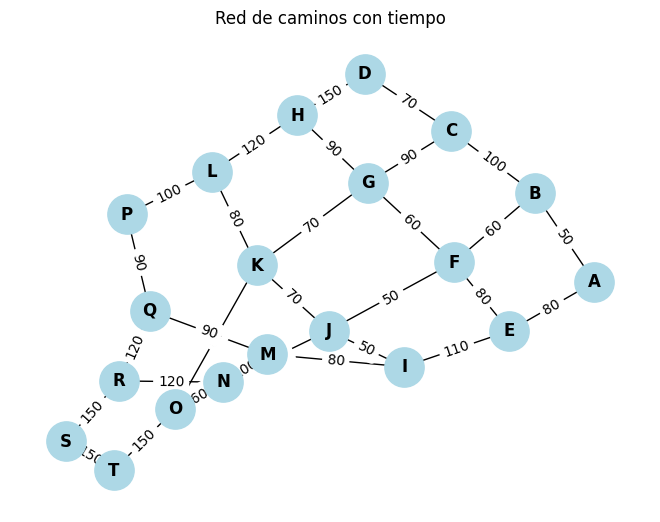

In [ ]:
# Visualizar el grafo de caminos pesados
pos = nx.spring_layout(G)
nx.draw(G,
        pos,
        with_labels=True,
        node_size=800,
        node_color="lightblue",
        font_size=12,
        font_color="black",
        font_weight="bold"
        )

# Dibujar etiquetas de pesos de aristas
edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Red de caminos con tiempo")
plt.show()

## Resolver el problema de camino mínimo utilizando directamente los pesos de las aristas.

Utilizaremos el algoritmo de Dijkstra para resolver el camino mínimo.

In [ ]:
# Definimos nodo de inicio y destino de nuestro camino
inicio = "A"
destino = "T"

# Cálculo
camino_minimo = nx.shortest_path(G, inicio, destino, weight="weight")
tiempo_minimo = nx.shortest_path_length(G, inicio, destino, weight="weight")

print("Camino mínimo:", camino_minimo)
print("Tiempo mínimo estimado:", tiempo_minimo, "minutos")


Camino mínimo: ['A', 'B', 'F', 'J', 'K', 'O', 'T']
Tiempo mínimo estimado: 440 minutos


## Definir y justificar distribuciones de tiempos para cada arista basadas en las estimaciones iniciales.

Teniendo en cuenta que realizaremos simulaciones de Monte Carlo, debemos definir las distribuciones de los tiempos de cada arista para modelar la incertidumbre.

*   **Gaussiana**: Asumimos que la mayoría de los tiempos de viaje están cerca de la estimación inicial, es decir, la cantidad de minutos que se tarda variará alrededor de un valor promedio (el definido inicialmente) y siguiendo una distribución simétrica. La desviación estándar a utilizar será un porcentaje de la media para reflejar nuestro nivel de incertidumbre (15% en este caso).
*   **Exponencial**: Si continuamos con la idea de considerar al valor inicial como la media de nuestra distribución, también podemos modelar el problema con una Exponencial, donde nuestro parámetro lamba (tasa de ocurrencia del evento por unidad de tiempo) es la inversa del valor inicial.
*   **Uniforme**: No contamos con mucha información sobre la variabilidad. Consideramos que no todas las aristas tienen la misma variabilidad, por lo que definiremos los límites inferiores y superiores en relación al valor inicial establecido para cada arista (+/- 20%).

## Utilizar las distribuciones del punto anterior para realizar diversas simulaciones para encontrar el camino mínimo.

Generaremos múltiples muestras aleatorias de tiempos de viaje para cada arista en función de la distribución respectiva para luego encontrar el camino mínimo en cada simulación.

In [ ]:
# Parámetros para simulación Monte Carlo
num_simulaciones = 1000  # Número de simulaciones

# Nodo de inicio y nodo de destino
inicio = "A"
destino = "T"

### Distribución Normal

In [ ]:
# Función para realizar una simulación
np.random.seed(2023)

def simulacion_normal():
    tiempos_simulados = {}
    for u, v, d in G.edges(data=True):
        peso_inicial = d["weight"]

        media_simulada = peso_inicial
        desviacion_simulada = media_simulada * 0.15  # 15% de la media inicial
        tiempo_simulado = np.random.normal(media_simulada, desviacion_simulada)
        tiempos_simulados[(u, v)] = tiempo_simulado


    # Crear un nuevo grafo con los tiempos simulados como pesos de las aristas
    G_simulado = G.copy()
    for u, v in G.edges():
        G_simulado[u][v]["weight"] = tiempos_simulados[(u, v)]


    # Encontrar el camino mínimo en el grafo simulado y el tiempo asociado al mismo
    camino_minimo = nx.shortest_path(G_simulado, inicio, destino, weight="weight")
    tiempo_total = nx.shortest_path_length(G_simulado, inicio, destino, weight="weight")

    return camino_minimo, tiempo_total

In [ ]:
# Realizar múltiples simulaciones de Monte Carlo
# En esta variable capturamos el camino y tiempo mínimo entre inicio y destino simulado mil veces
simulaciones_normal = [simulacion_normal() for _ in range(num_simulaciones)]

# Mostramos las primeras 6 simulaciones
simulaciones_normal[:6]

[(['A', 'B', 'F', 'G', 'K', 'O', 'T'], 417.13796745202546),
 (['A', 'B', 'F', 'J', 'N', 'O', 'T'], 379.01790548135364),
 (['A', 'B', 'F', 'G', 'K', 'O', 'T'], 513.0386637042855),
 (['A', 'B', 'F', 'G', 'K', 'O', 'T'], 428.3337456630102),
 (['A', 'B', 'F', 'J', 'K', 'O', 'T'], 442.35129554825915),
 (['A', 'B', 'F', 'G', 'K', 'O', 'T'], 430.878129253848)]

In [ ]:
# Resultados GLOBALES de las simulaciones
media_simulada = np.mean([resultado[1] for resultado in simulaciones_normal]).round(3)
desviacion_simulada = np.std([resultado[1] for resultado in simulaciones_normal]).round(3)

print("Media simulada:", media_simulada)
print("Desviación estándar simulada:", desviacion_simulada)

Media simulada: 436.236
Desviación estándar simulada: 29.074


### Exponencial

In [ ]:
# Función para realizar una simulación con distribución exponencial
np.random.seed(2023)

def simulacion_exponencial():
    tiempos_simulados = {}
    for u, v, d in G.edges(data=True):
        peso_inicial = d["weight"]

        # Lambda es igual a la inversa del valor de peso inicial
        lam = 1 / peso_inicial
        tiempo_simulado = np.random.exponential(scale=1/lam)
        tiempos_simulados[(u, v)] = tiempo_simulado

    # Crear un nuevo grafo con los tiempos simulados como pesos de las aristas
    G_simulado = G.copy()
    for u, v in G.edges():
        G_simulado[u][v]["weight"] = tiempos_simulados[(u, v)]

    # Encontrar el camino mínimo en el grafo simulado y el tiempo asociado al mismo
    camino_minimo = nx.shortest_path(G_simulado, inicio, destino, weight="weight")
    tiempo_total = nx.shortest_path_length(G_simulado, inicio, destino, weight="weight")

    return camino_minimo, tiempo_total


In [ ]:
# Realizar múltiples simulaciones de Monte Carlo
# En esta variable capturamos el camino y tiempo mínimo entre inicio y destino simulado mil veces
simulaciones_expo = [simulacion_exponencial() for _ in range(num_simulaciones)]

# Mostramos las primeras 6 simulaciones
simulaciones_expo[:6]

[(['A', 'B', 'C', 'G', 'K', 'O', 'T'], 278.5260150144961),
 (['A', 'B', 'F', 'G', 'K', 'O', 'T'], 339.022182380331),
 (['A', 'E', 'I', 'M', 'N', 'R', 'S', 'T'], 382.9982036932382),
 (['A', 'E', 'F', 'J', 'K', 'O', 'T'], 232.7089136938264),
 (['A', 'E', 'F', 'J', 'I', 'M', 'N', 'R', 'S', 'T'], 267.51289186610876),
 (['A', 'B', 'F', 'J', 'K', 'O', 'T'], 283.422827650967)]

In [ ]:
# Resultados GLOBALES de las simulaciones
media_simulada = np.mean([resultado[1] for resultado in simulaciones_expo]).round(3)
desviacion_simulada = np.std([resultado[1] for resultado in simulaciones_expo]).round(3)

print("Media simulada:", media_simulada)
print("Desviación estándar simulada:", desviacion_simulada)

Media simulada: 298.642
Desviación estándar simulada: 127.968


### Uniforme

In [ ]:
# Función para realizar una simulación con distribución uniforme
np.random.seed(2023)

def simulacion_uniforme():
    tiempos_simulados = {}
    for u, v, d in G.edges(data=True):
        peso_inicial = d["weight"]

        # Calcular los límites para la distribución uniforme
        limite_inferior = peso_inicial * 0.8  # 20% menos que el valor inicial
        limite_superior = peso_inicial * 1.2  # 20% más que el valor inicial

        # Generar un tiempo simulado a partir de la distribución uniforme
        tiempo_simulado = np.random.uniform(limite_inferior, limite_superior)

        tiempos_simulados[(u, v)] = tiempo_simulado

    # Crear un nuevo grafo con los tiempos simulados como pesos de las aristas
    G_simulado = G.copy()
    for u, v in G.edges():
        G_simulado[u][v]["weight"] = tiempos_simulados[(u, v)]

    # Encontrar el camino mínimo en el grafo simulado y el tiempo asociado al mismo
    camino_minimo = nx.shortest_path(G_simulado, inicio, destino, weight="weight")
    tiempo_total = nx.shortest_path_length(G_simulado, inicio, destino, weight="weight")

    return camino_minimo, tiempo_total

In [ ]:
# Realizar múltiples simulaciones de Monte Carlo
# En esta variable capturamos el camino y tiempo mínimo entre inicio y destino simulado mil veces
simulaciones_unif = [simulacion_uniforme() for _ in range(num_simulaciones)]

# Mostramos las primeras 6 simulaciones
simulaciones_unif[:6]

[(['A', 'B', 'F', 'J', 'K', 'O', 'T'], 387.16104816897774),
 (['A', 'B', 'F', 'J', 'K', 'O', 'T'], 462.9536012271869),
 (['A', 'B', 'F', 'J', 'K', 'O', 'T'], 406.88027855312157),
 (['A', 'B', 'F', 'J', 'K', 'O', 'T'], 492.7752322943429),
 (['A', 'B', 'F', 'J', 'K', 'O', 'T'], 424.085098876771),
 (['A', 'B', 'F', 'J', 'K', 'O', 'T'], 430.7080877379882)]

In [ ]:
# Resultados GLOBALES de las simulaciones
media_simulada = np.mean([resultado[1] for resultado in simulaciones_unif]).round(3)
desviacion_simulada = np.std([resultado[1] for resultado in simulaciones_unif]).round(3)

print("Media simulada:", media_simulada)
print("Desviación estándar simulada:", desviacion_simulada)

Media simulada: 437.476
Desviación estándar simulada: 22.912


## Argumentar qué camino sería finalmente elegido basándose en la esperanza y la varianza de los diferentes caminos.

La elección final dependerá de las preferencias y restricciones del viajero.

Por ejemplo, si se valora más la puntualidad, se puede elegir un camino con menor varianza, incluso si la esperanza es un poco más larga. Si se busca minimizar el tiempo promedio, se elegirá el camino con la menor esperanza, incluso si la varianza es un poco mayor.

La elección final será una compensación entre estas dos consideraciones.

### Normal

Si evaluamos los caminos encontrados para conectar el punto A con el T vemos que la mayor parte de las simulaciones se concentran entre el camino ('A', 'B', 'F', 'J', 'K', 'O', 'T') y el ('A', 'B', 'F', 'G', 'K', 'O', 'T'), siendo el primero superior por registrar un tiempo medio y un desvío estándar menor.

El camino ('A', 'B', 'C', 'G', 'K', 'O', 'T') es el que cuenta con menor tiempo medio (aparece en una única simulación de las mil realizadas). Por razones obvias, los caminos con menor desvío son los que se hacen presentes en una menor cantidad de simulaciones.

In [ ]:
# Crear un diccionario para almacenar los tiempos totales de cada camino mínimo único
caminos_unicos = {}

for camino, tiempo_total in simulaciones_normal:

    # Convierte el camino en una tupla ordenada para que sea un hashable (pueda usarse como clave de diccionario)
    camino_tupla = tuple(camino)

    # Almacena el tiempo total en el diccionario, agrupando por caminos únicos
    if camino_tupla in caminos_unicos:
        caminos_unicos[camino_tupla].append(tiempo_total)
    else:
        caminos_unicos[camino_tupla] = [tiempo_total]


# Calcula la media y desviación estándar para cada camino único
for camino, tiempos in caminos_unicos.items():
    media_simulada = np.mean(tiempos).round(2)
    desviacion_simulada = np.std(tiempos).round(2)
    cantidad_datos = len(tiempos)  # Cantidad de datos para este camino
    print(f"Camino {camino}:")
    print("Cantidad de simulaciones:", cantidad_datos)
    print("Media simulada:", media_simulada)
    print("Desviación estándar simulada:", desviacion_simulada)
    print("")

Camino ('A', 'B', 'F', 'G', 'K', 'O', 'T'):
Cantidad de simulaciones: 275
Media simulada: 435.31
Desviación estándar simulada: 30.54

Camino ('A', 'B', 'F', 'J', 'N', 'O', 'T'):
Cantidad de simulaciones: 60
Media simulada: 440.18
Desviación estándar simulada: 24.06

Camino ('A', 'B', 'F', 'J', 'K', 'O', 'T'):
Cantidad de simulaciones: 656
Media simulada: 435.97
Desviación estándar simulada: 28.81

Camino ('A', 'E', 'F', 'J', 'K', 'O', 'T'):
Cantidad de simulaciones: 5
Media simulada: 450.53
Desviación estándar simulada: 16.56

Camino ('A', 'E', 'F', 'J', 'N', 'O', 'T'):
Cantidad de simulaciones: 2
Media simulada: 490.28
Desviación estándar simulada: 1.23

Camino ('A', 'E', 'F', 'G', 'K', 'O', 'T'):
Cantidad de simulaciones: 1
Media simulada: 451.69
Desviación estándar simulada: 0.0

Camino ('A', 'B', 'C', 'G', 'K', 'O', 'T'):
Cantidad de simulaciones: 1
Media simulada: 432.54
Desviación estándar simulada: 0.0



### Exponencial

La cantidad de caminos definidos a lo largo de las mil simulaciones es superior a los resultantes con la distribución Normal o Uniforme.

Siguiendo con las comparaciones, es fácil detectar que la mayor parte de estos caminos cuentan con un tiempo medio menor, pero con un nivel de variabilidad mucho más alto (se puede ver en las métricas globales definidas en el punto anterior).

El camino ('A', 'B', 'C', 'G', 'H', 'L', 'K', 'O', 'T'), presente en dos simulaciones, registra la menor media (170.13).

El camino ('A', 'B', 'F', 'J', 'K', 'O', 'T') es el que más se repitió a lo largo de las mil simulaciones, contando con una media baja (281.51), pero con una gran variabilidad (123.37).


In [ ]:
# Crear un diccionario para almacenar los tiempos totales de cada camino mínimo único
caminos_unicos = {}

for camino, tiempo_total in simulaciones_expo:

    # Convierte el camino en una tupla ordenada para que sea un hashable (pueda usarse como clave de diccionario)
    camino_tupla = tuple(camino)

    # Almacena el tiempo total en el diccionario, agrupando por caminos únicos
    if camino_tupla in caminos_unicos:
        caminos_unicos[camino_tupla].append(tiempo_total)
    else:
        caminos_unicos[camino_tupla] = [tiempo_total]


# Calcula la media y desviación estándar para cada camino único
for camino, tiempos in caminos_unicos.items():
    media_simulada = np.mean(tiempos).round(2)
    desviacion_simulada = np.std(tiempos).round(2)
    cantidad_datos = len(tiempos)  # Cantidad de datos para este camino
    print(f"Camino {camino}:")
    print("Cantidad de simulaciones:", cantidad_datos)
    print("Media simulada:", media_simulada)
    print("Desviación estándar simulada:", desviacion_simulada)
    print("")

Camino ('A', 'B', 'C', 'G', 'K', 'O', 'T'):
Cantidad de simulaciones: 82
Media simulada: 327.22
Desviación estándar simulada: 135.09

Camino ('A', 'B', 'F', 'G', 'K', 'O', 'T'):
Cantidad de simulaciones: 135
Media simulada: 286.52
Desviación estándar simulada: 131.55

Camino ('A', 'E', 'I', 'M', 'N', 'R', 'S', 'T'):
Cantidad de simulaciones: 18
Media simulada: 358.93
Desviación estándar simulada: 153.19

Camino ('A', 'E', 'F', 'J', 'K', 'O', 'T'):
Cantidad de simulaciones: 69
Media simulada: 291.76
Desviación estándar simulada: 110.76

Camino ('A', 'E', 'F', 'J', 'I', 'M', 'N', 'R', 'S', 'T'):
Cantidad de simulaciones: 2
Media simulada: 459.53
Desviación estándar simulada: 192.02

Camino ('A', 'B', 'F', 'J', 'K', 'O', 'T'):
Cantidad de simulaciones: 115
Media simulada: 281.51
Desviación estándar simulada: 123.37

Camino ('A', 'E', 'F', 'J', 'N', 'O', 'T'):
Cantidad de simulaciones: 50
Media simulada: 281.42
Desviación estándar simulada: 120.15

Camino ('A', 'E', 'I', 'M', 'N', 'O', 'T'

### Uniforme

En este caso solo se detectaron tres caminos para unir el punto A con el punto T, presentando tiempos medios y desvíos estándar muy similares entre sí.

In [ ]:
# Crear un diccionario para almacenar los tiempos totales de cada camino mínimo único
caminos_unicos = {}

for camino, tiempo_total in simulaciones_unif:

    # Convierte el camino en una tupla ordenada para que sea un hashable (pueda usarse como clave de diccionario)
    camino_tupla = tuple(camino)

    # Almacena el tiempo total en el diccionario, agrupando por caminos únicos
    if camino_tupla in caminos_unicos:
        caminos_unicos[camino_tupla].append(tiempo_total)
    else:
        caminos_unicos[camino_tupla] = [tiempo_total]


# Calcula la media y desviación estándar para cada camino único
for camino, tiempos in caminos_unicos.items():
    media_simulada = np.mean(tiempos).round(2)
    desviacion_simulada = np.std(tiempos).round(2)
    cantidad_datos = len(tiempos)  # Cantidad de datos para este camino
    print(f"Camino {camino}:")
    print("Cantidad de simulaciones:", cantidad_datos)
    print("Media simulada:", media_simulada)
    print("Desviación estándar simulada:", desviacion_simulada)
    print("")

Camino ('A', 'B', 'F', 'J', 'K', 'O', 'T'):
Cantidad de simulaciones: 735
Media simulada: 436.71
Desviación estándar simulada: 22.79

Camino ('A', 'B', 'F', 'G', 'K', 'O', 'T'):
Cantidad de simulaciones: 239
Media simulada: 438.89
Desviación estándar simulada: 23.38

Camino ('A', 'B', 'F', 'J', 'N', 'O', 'T'):
Cantidad de simulaciones: 26
Media simulada: 446.1
Desviación estándar simulada: 19.18

